<a href="https://colab.research.google.com/github/paddy3696/CNN_Pytorch/blob/main/Inat_cnn_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Apr 17 20:08:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt

In [20]:
train_gpu = torch.cuda.is_available()

if not train_gpu:
    print('CUDA is not available. Training on CPU')
else:
    print('CUDA is available! Training on GPU')

CUDA is available! Training on GPU


In [4]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=6ec559c56357a1d00310c7a0c6078afec892bb0cd9f7537075eead2d14ecb212
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [5]:
import wget
wget.download('https://storage.googleapis.com/wandb_datasets/nature_12K.zip')

'nature_12K.zip'

In [ ]:
!unzip /content/nature_12K.zip

Define Model

In [7]:
class MyNN(nn.Module):
  def __init__(self, drop_out = 0.2, batch_norm = 'Yes', filter_n = 32,  filter_org = 'same',hidden_out = 128):

    super(MyNN,self).__init__()
    
    self.drop_out = drop_out
    self.batch_norm = batch_norm
    self.filter_n = filter_n
    self.filter_org = filter_org
    self.hidden_out = hidden_out
    
    if self.filter_org == 'same':
      self.conv_1 = nn.Conv2d(3,self.filter_n,kernel_size=3,padding=1)
      self.conv_1_bn = nn.BatchNorm2d(self.filter_n)
      self.conv_2 = nn.Conv2d(self.filter_n,self.filter_n,kernel_size=3,padding=1)
      self.conv_2_bn = nn.BatchNorm2d(self.filter_n)
      self.conv_3 = nn.Conv2d(self.filter_n,self.filter_n,kernel_size=3,padding=1)
      self.conv_3_bn = nn.BatchNorm2d(self.filter_n)
      self.conv_4 = nn.Conv2d(self.filter_n,self.filter_n,kernel_size=3,padding=1)
      self.conv_4_bn = nn.BatchNorm2d(self.filter_n)
      self.conv_5 = nn.Conv2d(self.filter_n,self.filter_n,kernel_size=3,padding=1)
      self.conv_5_bn = nn.BatchNorm2d(self.filter_n)

      self.fc1 = nn.Linear(self.filter_n*7*7,self.hidden_out)
      self.fc2 = nn.Linear(self.hidden_out,10)

    if self.filter_org == 'double_up':
      self.conv_1 = nn.Conv2d(3,self.filter_n,kernel_size=3,padding=1)
      self.conv_1_bn = nn.BatchNorm2d(self.filter_n)
      self.conv_2 = nn.Conv2d(self.filter_n,self.filter_n*2,kernel_size=3,padding=1)
      self.conv_2_bn = nn.BatchNorm2d(self.filter_n*2)
      self.conv_3 = nn.Conv2d(self.filter_n*2,self.filter_n*4,kernel_size=3,padding=1)
      self.conv_3_bn = nn.BatchNorm2d(self.filter_n*4)
      self.conv_4 = nn.Conv2d(self.filter_n*4,self.filter_n*8,kernel_size=3,padding=1)
      self.conv_4_bn = nn.BatchNorm2d(self.filter_n*8)
      self.conv_5 = nn.Conv2d(self.filter_n*8,self.filter_n*16,kernel_size=3,padding=1)
      self.conv_5_bn = nn.BatchNorm2d(self.filter_n*16)

      self.fc1 = nn.Linear(self.filter_n*16*7*7,self.hidden_out)
      self.fc2 = nn.Linear(self.hidden_out,10)

    if self.filter_org == 'double_down':
      self.conv_1 = nn.Conv2d(3,self.filter_n,kernel_size=3,padding=1)
      self.conv_1_bn = nn.BatchNorm2d(self.filter_n)
      self.conv_2 = nn.Conv2d(self.filter_n, int(self.filter_n/2),kernel_size=3,padding=1)
      self.conv_2_bn = nn.BatchNorm2d(int(self.filter_n/2))
      self.conv_3 = nn.Conv2d(int(self.filter_n/2), int(self.filter_n/4),kernel_size=3,padding=1)
      self.conv_3_bn = nn.BatchNorm2d(int(self.filter_n/4))
      self.conv_4 = nn.Conv2d(int(self.filter_n/4), int(self.filter_n/8),kernel_size=3,padding=1)
      self.conv_4_bn = nn.BatchNorm2d(int(self.filter_n/8))
      self.conv_5 = nn.Conv2d(int(self.filter_n/8), int(self.filter_n/16),kernel_size=3,padding=1)
      self.conv_5_bn = nn.BatchNorm2d(int(self.filter_n/16))

      self.fc1 = nn.Linear(int(self.filter_n/16)*7*7,self.hidden_out)
      self.fc2 = nn.Linear(self.hidden_out,10)

    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(self.drop_out)

  def forward(self,x):
    if self.batch_norm == 'Yes':
      x = self.pool(F.relu(self.conv_1_bn(self.conv_1(x))))
      x = self.pool(F.relu(self.conv_2_bn(self.conv_2(x))))
      x = self.pool(F.relu(self.conv_3_bn(self.conv_3(x))))
      x = self.pool(F.relu(self.conv_4_bn(self.conv_4(x))))
      x = self.pool(F.relu(self.conv_5_bn(self.conv_5(x))))
      if self.filter_org == 'same':
        x = x.view(-1,self.filter_n*7*7)
      elif self.filter_org == 'double_up':
        x = x.view(-1,self.filter_n*16*7*7)
      elif self.filter_org == 'double_down':
        x = x.view(-1,int(self.filter_n/16)*7*7)
      x = self.dropout(x)
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = self.fc2(x)

    if self.batch_norm == 'No':
      x = self.pool(F.relu(self.conv_1(x)))
      x = self.pool(F.relu(self.conv_2(x)))
      x = self.pool(F.relu(self.conv_3(x)))
      x = self.pool(F.relu(self.conv_4(x)))
      x = self.pool(F.relu(self.conv_5(x)))
      if self.filter_org == 'same':
        x = x.view(-1,self.filter_n*7*7)
      elif self.filter_org == 'double_up':
        x = x.view(-1,self.filter_n*16*7*7)
      elif self.filter_org == 'double_down':
        x = x.view(-1,int(self.filter_n/16)*7*7)
      x = self.dropout(x)
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = self.fc2(x)

    #return F.log_softmax(x,dim= 1)
    return x

Model Training

In [8]:
def fit(model,train_loader,val_loader,optimizer,epoch,criterion):
  acc_epoch = []

  for epoch in range(1, epoch+1):
    train_loss = 0.0
    val_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    print('training started')
    model.train()
    for data, target in train_loader:
      if train_gpu:
        data, target = data.cuda(), target.cuda()
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()*data.size(0)

    train_loss = train_loss/len(train_loader.sampler)
    print('Training over')

    model.eval()
    for data, target in val_loader:
      batch_data_size = data.size(0)
      if train_gpu:
        data, target = data.cuda(), target.cuda()
      output = model(data)
      loss = criterion(output, target)
      val_loss += loss.item()*data.size(0)

      _, pred = torch.max(output, 1)    
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not train_gpu else np.squeeze(correct_tensor.cpu().numpy())
      for i in range(batch_data_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
    val_loss = val_loss/len(val_loader.sampler)
    val_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
    acc_epoch.append(val_accuracy)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))
    print('Val Accuracy (Overall): %.2f%% (%2d/%2d)\n' % (val_accuracy,np.sum(class_correct), np.sum(class_total)))

  torch.save(model.state_dict(), 'model_inat.pt')

In [9]:
def train(epoch = 10,batch_size = 32,drop_out = 0.2, batch_norm = 'Yes', filter_n = 128,  filter_org = 'double_down', hidden_out =196):
  data_dir = '/content/inaturalist_12K'
                                
  train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.ToTensor()])
  train_data = datasets.ImageFolder(data_dir + '/train',transform=train_transforms)

  batch_size = batch_size
  validation_split = .1
  shuffle_dataset = True
  random_seed= 9

  dataset_size = len(train_data)
  indices = list(range(dataset_size))
  split = int(np.floor(validation_split * dataset_size))
  if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

  train_indices, val_indices = indices[split:], indices[:split]

  train_sampler = SubsetRandomSampler(train_indices)
  valid_sampler = SubsetRandomSampler(val_indices)

  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=train_sampler)
  val_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=valid_sampler)
  print('data ready')
    
  model = MyNN(drop_out = drop_out, batch_norm = batch_norm, filter_n = filter_n,  filter_org = filter_org, hidden_out = hidden_out)
  print(model)

  if train_gpu:
    model.cuda()

  criterion = nn.CrossEntropyLoss()

  optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.1) 
  fit(model,train_loader,val_loader,optimizer,epoch,criterion)

In [ ]:
train(epoch = 10,batch_size = 32,drop_out = 0.2, batch_norm = 'Yes', filter_n = 128,  filter_org = 'double_down', hidden_out =196)

Model Testing

In [22]:
model = MyNN(drop_out = 0.2, batch_norm = 'Yes', filter_n = 128,  filter_org = 'double_down', hidden_out =196)
#model = torch.load('/content/model_inat.pt')
model.load_state_dict(torch.load('model_inat.pt'))
if train_gpu:
  model.cuda()

In [25]:
def test(model,batch_size = 32):
  batch_size = batch_size
  data_dir = '/content/inaturalist_12K'
  test_transforms = transforms.Compose([transforms.Resize(255),transforms.CenterCrop(224),transforms.ToTensor()])
  test_data = datasets.ImageFolder(data_dir + '/val', transform=test_transforms)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

  test_loss = 0.0
  class_correct = list(0. for i in range(10))
  class_total = list(0. for i in range(10))
  criterion = nn.CrossEntropyLoss()

  model.eval()
  for data, target in test_loader:
    batch_data_size = data.size(0)
    if train_gpu:
      data, target = data.cuda(), target.cuda()
    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)    
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(batch_data_size):
      label = target.data[i]
      class_correct[label] += correct[i].item()
      class_total[label] += 1
      
  test_loss = test_loss/len(test_loader.sampler)
  test_accuracy = 100. * np.sum(class_correct) / np.sum(class_total)
  print('Val Accuracy (Overall): %.2f%% (%2d/%2d)\n' % (test_accuracy,np.sum(class_correct), np.sum(class_total)))

In [26]:
test(model,batch_size = 32)

Val Accuracy (Overall): 24.30% (486/2000)



Output Visualization

In [27]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 

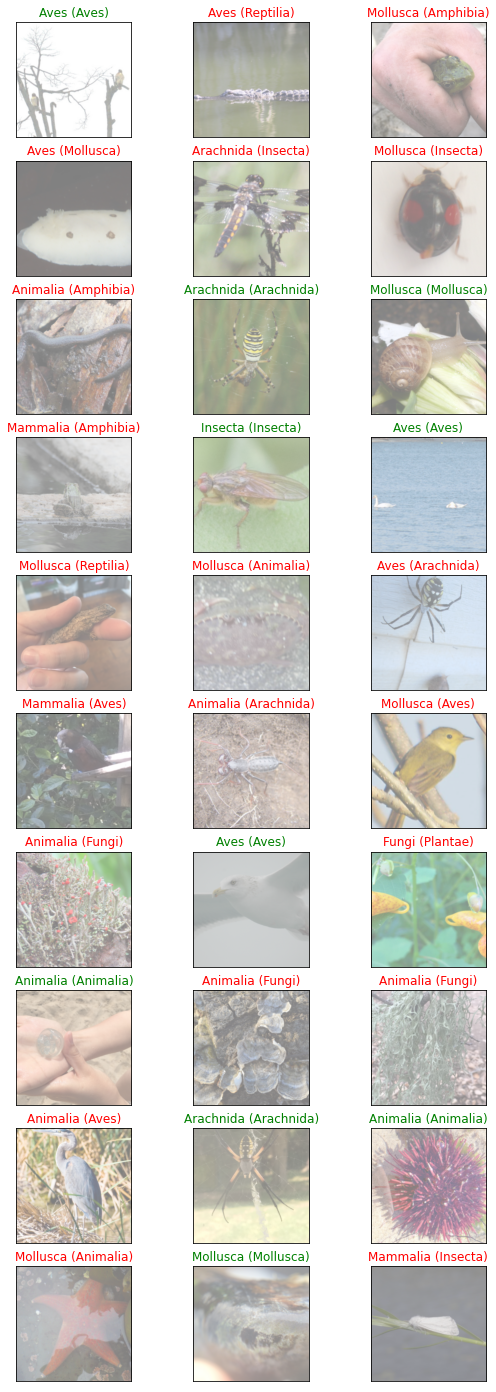

In [28]:
batch_size = 32
data_dir = '/content/inaturalist_12K'
test_transforms = transforms.Compose([transforms.Resize(255),transforms.CenterCrop(224),transforms.ToTensor()])
test_data = datasets.ImageFolder(data_dir + '/val', transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

classes = ['Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']

dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

if train_gpu:
    images = images.cuda()

output = model(images)

_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_gpu else np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize=(9, 25))
for idx in np.arange(30):
    ax = fig.add_subplot(10, 3, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

Feature Map

In [29]:
!pip install mapextrackt
from MapExtrackt import FeatureExtractor
from PIL import Image 

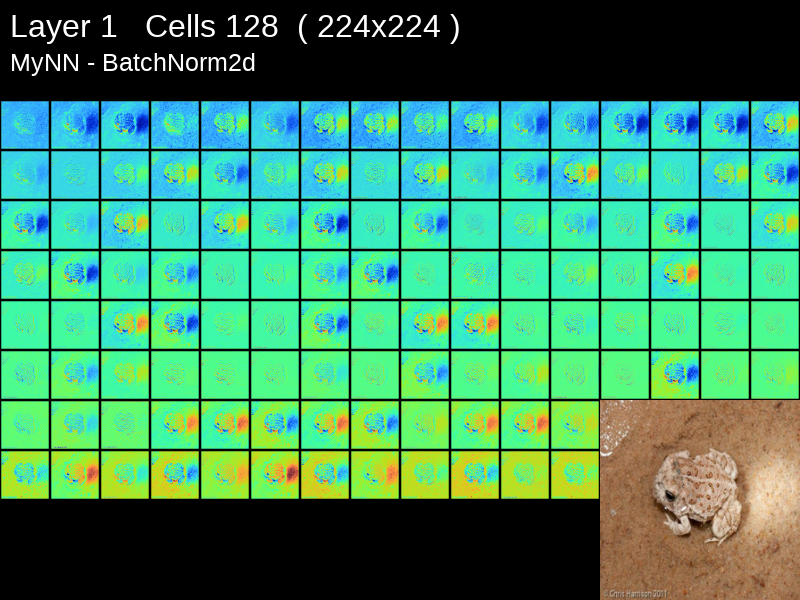

In [30]:
visualize = FeatureExtractor(model) 
# Opens a image in RGB mode 
im = Image.open(r"/content/inaturalist_12K/val/Amphibia/1883c3b203ab4b4ce75ad00e35469462.jpg") 

newsize = (224, 224)
im1 = im.resize(newsize)
im1.save('my.png')

visualize.set_image("/content/my.png")
visualize.display_from_map(layer_no=1)